# Extract Journal Scores to DataFrame

This notebook processes all markdown journal files from a specified directory,
extracts wellbeing scores using the existing JournalEntry parsing logic,
and outputs a comprehensive pandas DataFrame with both raw individual scores
and computed scaled metrics.

## Features
- Raw PANAS Positive/Negative scores (20 individual columns)
- Raw BPNS scores (7 individual columns) 
- Raw Flourishing scores (8 individual columns)
- Computed scaled scores (7 columns)
- Console warnings for missing data
- CSV export functionality


## Setup and Imports


In [14]:
import sys
import warnings
from pathlib import Path
from datetime import date
from typing import List, Optional, Dict, Any
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Add the src directory to the path to import minerva_backend modules
sys.path.insert(0, str(Path.cwd().parent / "src"))

from minerva_backend.graph.models.documents import JournalEntry

print("Imports successful!")


Imports successful!


## Helper Functions


In [15]:
def extract_date_from_filename(filename: str) -> Optional[date]:
    """Extract date from filename in format YYYY-MM-DD.md"""
    try:
        # Remove .md extension and parse date
        date_str = filename.replace('.md', '')
        year, month, day = date_str.split('-')
        return date(int(year), int(month), int(day))
    except (ValueError, AttributeError):
        return None

print("Helper functions defined!")


Helper functions defined!


In [16]:
def calculate_scaled_scores(panas_pos: Optional[List[float]], 
                          panas_neg: Optional[List[float]], 
                          bpns: Optional[List[float]], 
                          flourishing: Optional[List[float]]) -> Dict[str, float]:
    """Calculate scaled scores using the formulas from journal markdown files"""
    scores = {}
    
    # PANAS Positive scaled: (sum - 10) / (50 - 10) * 100
    if panas_pos and len(panas_pos) == 10:
        panas_pos_sum = sum(panas_pos)
        scores['panas_pos_scaled'] = (panas_pos_sum - 10) / (50 - 10) * 100
    else:
        scores['panas_pos_scaled'] = np.nan
    
    # PANAS Negative scaled: (sum - 10) / (50 - 10) * 100
    if panas_neg and len(panas_neg) == 10:
        panas_neg_sum = sum(panas_neg)
        scores['panas_neg_scaled'] = (panas_neg_sum - 10) / (50 - 10) * 100
    else:
        scores['panas_neg_scaled'] = np.nan
    
    # BPNS scores (7 items total: 2 autonomy + 2 competence + 3 relatedness)
    if bpns and len(bpns) == 7:
        autonomy_sum = bpns[0] + bpns[1]  # First 2 items
        competence_sum = bpns[2] + bpns[3]  # Next 2 items
        relatedness_sum = bpns[4] + bpns[5] + bpns[6]  # Last 3 items
        bpns_total = autonomy_sum + competence_sum + relatedness_sum
        
        # Individual scaled scores
        scores['bpns_autonomy_scaled'] = (autonomy_sum - 2) / (14 - 2) * 100
        scores['bpns_competence_scaled'] = (competence_sum - 2) / (14 - 2) * 100
        scores['bpns_relatedness_scaled'] = (relatedness_sum - 3) / (21 - 3) * 100
        scores['bpns_total_scaled'] = (bpns_total - 7) / (49 - 7) * 100
    else:
        scores['bpns_autonomy_scaled'] = np.nan
        scores['bpns_competence_scaled'] = np.nan
        scores['bpns_relatedness_scaled'] = np.nan
        scores['bpns_total_scaled'] = np.nan
    
    # Flourishing scaled: (sum - 8) / (56 - 8) * 100
    if flourishing and len(flourishing) == 8:
        flourishing_sum = sum(flourishing)
        scores['flourishing_scaled'] = (flourishing_sum - 8) / (56 - 8) * 100
    else:
        scores['flourishing_scaled'] = np.nan
    
    return scores

print("Scaled score calculation function defined!")


Scaled score calculation function defined!


In [17]:
def extract_raw_scores(panas_pos: Optional[List[float]], 
                      panas_neg: Optional[List[float]], 
                      bpns: Optional[List[float]], 
                      flourishing: Optional[List[float]]) -> Dict[str, Any]:
    """Extract individual raw scores into separate columns"""
    scores = {}
    
    # PANAS Positive scores (10 items)
    panas_pos_labels = ['interested', 'excited', 'strong', 'enthusiastic', 'proud', 
                       'alert', 'inspired', 'determined', 'attentive', 'active']
    if panas_pos and len(panas_pos) == 10:
        for i, label in enumerate(panas_pos_labels):
            scores[f'panas_pos_{label}'] = panas_pos[i]
    else:
        for label in panas_pos_labels:
            scores[f'panas_pos_{label}'] = np.nan
    
    # PANAS Negative scores (10 items)
    panas_neg_labels = ['distressed', 'upset', 'guilty', 'scared', 'hostile', 
                       'irritable', 'ashamed', 'nervous', 'jittery', 'afraid']
    if panas_neg and len(panas_neg) == 10:
        for i, label in enumerate(panas_neg_labels):
            scores[f'panas_neg_{label}'] = panas_neg[i]
    else:
        for label in panas_neg_labels:
            scores[f'panas_neg_{label}'] = np.nan
    
    # BPNS scores (7 items)
    bpns_labels = ['autonomy_choices', 'autonomy_tasks', 'competence_capable', 
                  'competence_challenges', 'relatedness_connected', 'relatedness_along', 
                  'relatedness_supported']
    if bpns and len(bpns) == 7:
        for i, label in enumerate(bpns_labels):
            scores[f'bpns_{label}'] = bpns[i]
    else:
        for label in bpns_labels:
            scores[f'bpns_{label}'] = np.nan
    
    # Flourishing scores (8 items)
    flourishing_labels = ['purposeful', 'relationships', 'engaged', 'contribute', 
                         'competent', 'good_person', 'optimistic', 'respected']
    if flourishing and len(flourishing) == 8:
        for i, label in enumerate(flourishing_labels):
            scores[f'flourishing_{label}'] = flourishing[i]
    else:
        for label in flourishing_labels:
            scores[f'flourishing_{label}'] = np.nan
    
    return scores

print("Raw score extraction function defined!")


Raw score extraction function defined!


In [18]:
def process_journal_file(file_path: Path) -> Optional[Dict[str, Any]]:
    """Process a single journal file and extract all scores"""
    try:
        # Read file content
        with open(file_path, 'r', encoding='utf-8') as f:
            content = f.read()
        
        # Extract date from filename
        journal_date = extract_date_from_filename(file_path.name)
        if not journal_date:
            print(f"WARNING: Could not extract date from filename: {file_path.name}")
            return None
        
        # Parse journal entry using existing JournalEntry logic
        journal_entry = JournalEntry.from_text(content, journal_date.isoformat())
        
        # Prepare result dictionary
        result = {'date': journal_date}
        
        # Check for missing scores and print warnings
        filename = file_path.name
        if not journal_entry.panas_pos:
            print(f"WARNING: Missing PANAS positive scores for {filename}")
        if not journal_entry.panas_neg:
            print(f"WARNING: Missing PANAS negative scores for {filename}")
        if not journal_entry.bpns:
            print(f"WARNING: Missing BPNS scores for {filename}")
        if not journal_entry.flourishing:
            print(f"WARNING: Missing Flourishing scores for {filename}")
        
        # Extract raw scores
        raw_scores = extract_raw_scores(
            journal_entry.panas_pos,
            journal_entry.panas_neg,
            journal_entry.bpns,
            journal_entry.flourishing
        )
        result.update(raw_scores)
        
        # Calculate scaled scores
        scaled_scores = calculate_scaled_scores(
            journal_entry.panas_pos,
            journal_entry.panas_neg,
            journal_entry.bpns,
            journal_entry.flourishing
        )
        result.update(scaled_scores)
        
        return result
        
    except Exception as e:
        print(f"ERROR: Failed to process {file_path.name}: {e}")
        return None

print("Journal file processing function defined!")


Journal file processing function defined!


## Configuration

Set the directory path to process. Default is `D:\yo\02 - Daily Notes`


In [19]:
# Set the directory path to process
directory_path = Path(r"D:\yo\02 - Daily Notes")

# Alternative: Use test data
# directory_path = Path("../test_scripts/notes")

print(f"Target directory: {directory_path}")
print(f"Directory exists: {directory_path.exists()}")


Target directory: D:\yo\02 - Daily Notes
Directory exists: True


## Process Journal Files


In [20]:
# Check if directory exists
if not directory_path.exists():
    print(f"ERROR: Directory does not exist: {directory_path}")
    print("Please update the directory_path variable above.")
else:
    print(f"Processing journal files from: {directory_path}")
    
    # Find all .md files
    md_files = list(directory_path.glob("*.md"))
    if not md_files:
        print("No .md files found in the directory")
    else:
        print(f"Found {len(md_files)} markdown files")
        print("Files to process:")
        for file_path in sorted(md_files):
            print(f"  - {file_path.name}")


Processing journal files from: D:\yo\02 - Daily Notes
Found 88 markdown files
Files to process:
  - 2025-02-16.md
  - 2025-03-22.md
  - 2025-04-11.md
  - 2025-05-20.md
  - 2025-07-13.md
  - 2025-07-15.md
  - 2025-07-17.md
  - 2025-07-18.md
  - 2025-07-19.md
  - 2025-07-20.md
  - 2025-07-21.md
  - 2025-07-22.md
  - 2025-07-23.md
  - 2025-07-24.md
  - 2025-07-25.md
  - 2025-07-26.md
  - 2025-07-27.md
  - 2025-07-28.md
  - 2025-07-29.md
  - 2025-07-30.md
  - 2025-07-31.md
  - 2025-08-01.md
  - 2025-08-02.md
  - 2025-08-03.md
  - 2025-08-04.md
  - 2025-08-05.md
  - 2025-08-06.md
  - 2025-08-07.md
  - 2025-08-08.md
  - 2025-08-09.md
  - 2025-08-10.md
  - 2025-08-11.md
  - 2025-08-12.md
  - 2025-08-13.md
  - 2025-08-14.md
  - 2025-08-15.md
  - 2025-08-16.md
  - 2025-08-17.md
  - 2025-08-18.md
  - 2025-08-19.md
  - 2025-08-20.md
  - 2025-08-21.md
  - 2025-08-22.md
  - 2025-08-23.md
  - 2025-08-24.md
  - 2025-08-25.md
  - 2025-08-26.md
  - 2025-08-27.md
  - 2025-08-28.md
  - 2025-08-29.md
  - 

In [21]:
# Process each file
if directory_path.exists() and md_files:
    all_scores = []
    
    for file_path in sorted(md_files):
        print(f"\nProcessing: {file_path.name}")
        scores = process_journal_file(file_path)
        if scores:
            all_scores.append(scores)
            print(f"  ✓ Successfully processed")
        else:
            print(f"  ✗ Failed to process")
    
    print(f"\nTotal files processed: {len(all_scores)} out of {len(md_files)}")
else:
    all_scores = []
    print("No files to process.")



Processing: 2025-02-16.md
  ✓ Successfully processed

Processing: 2025-03-22.md
  ✓ Successfully processed

Processing: 2025-04-11.md
  ✓ Successfully processed

Processing: 2025-05-20.md
  ✓ Successfully processed

Processing: 2025-07-13.md
  ✓ Successfully processed

Processing: 2025-07-15.md
  ✓ Successfully processed

Processing: 2025-07-17.md
  ✓ Successfully processed

Processing: 2025-07-18.md
  ✓ Successfully processed

Processing: 2025-07-19.md
  ✓ Successfully processed

Processing: 2025-07-20.md
  ✓ Successfully processed

Processing: 2025-07-21.md
  ✓ Successfully processed

Processing: 2025-07-22.md
  ✓ Successfully processed

Processing: 2025-07-23.md
  ✓ Successfully processed

Processing: 2025-07-24.md
  ✓ Successfully processed

Processing: 2025-07-25.md
  ✓ Successfully processed

Processing: 2025-07-26.md
  ✓ Successfully processed

Processing: 2025-07-27.md
  ✓ Successfully processed

Processing: 2025-07-28.md
  ✓ Successfully processed

Processing: 2025-07-29.md
 

## Create DataFrame


In [22]:
if all_scores:
    # Create DataFrame
    df = pd.DataFrame(all_scores)
    
    # Sort by date
    df = df.sort_values('date').reset_index(drop=True)
    
    print(f"Successfully created DataFrame with {len(df)} journal entries")
    print(f"DataFrame shape: {df.shape}")
    print(f"Columns: {len(df.columns)}")
else:
    print("No data to create DataFrame")
    df = None


Successfully created DataFrame with 88 journal entries
DataFrame shape: (88, 43)
Columns: 43


## Display DataFrame Information


In [23]:
if df is not None:
    print("DataFrame Info:")
    print(df.info())
    
    print("\nFirst 5 rows:")
    display(df.head())
    
    print("\nLast 5 rows:")
    display(df.tail())


DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 43 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   date                        88 non-null     object 
 1   panas_pos_interested        42 non-null     float64
 2   panas_pos_excited           42 non-null     float64
 3   panas_pos_strong            42 non-null     float64
 4   panas_pos_enthusiastic      42 non-null     float64
 5   panas_pos_proud             42 non-null     float64
 6   panas_pos_alert             42 non-null     float64
 7   panas_pos_inspired          42 non-null     float64
 8   panas_pos_determined        42 non-null     float64
 9   panas_pos_attentive         42 non-null     float64
 10  panas_pos_active            42 non-null     float64
 11  panas_neg_distressed        42 non-null     float64
 12  panas_neg_upset             42 non-null     float64
 13  panas_neg_guilty     

,date,panas_pos_interested,panas_pos_excited,panas_pos_strong,panas_pos_enthusiastic,panas_pos_proud,panas_pos_alert,panas_pos_inspired,panas_pos_determined,panas_pos_attentive,...,flourishing_good_person,flourishing_optimistic,flourishing_respected,panas_pos_scaled,panas_neg_scaled,bpns_autonomy_scaled,bpns_competence_scaled,bpns_relatedness_scaled,bpns_total_scaled,flourishing_scaled
0,2025-02-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-03-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2025-04-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2025-05-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2025-07-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Last 5 rows:


,date,panas_pos_interested,panas_pos_excited,panas_pos_strong,panas_pos_enthusiastic,panas_pos_proud,panas_pos_alert,panas_pos_inspired,panas_pos_determined,panas_pos_attentive,...,flourishing_good_person,flourishing_optimistic,flourishing_respected,panas_pos_scaled,panas_neg_scaled,bpns_autonomy_scaled,bpns_competence_scaled,bpns_relatedness_scaled,bpns_total_scaled,flourishing_scaled
83,2025-10-02,3.0,2.0,3.0,4.0,3.0,2.0,3.0,3.0,4.0,...,4.0,4.0,4.0,50.0,7.5,66.666667,83.333333,77.777778,76.190476,56.250000
84,2025-10-03,3.0,3.0,2.0,3.0,3.0,2.0,2.0,4.0,2.0,...,5.0,4.0,5.0,40.0,2.5,75.000000,58.333333,83.333333,73.809524,58.333333
85,2025-10-04,3.0,4.0,3.0,3.0,3.0,3.0,4.0,4.0,3.0,...,6.0,4.0,4.0,60.0,0.0,83.333333,75.000000,94.444444,85.714286,75.000000
86,2025-10-05,4.0,4.0,4.0,4.0,4.0,4.0,3.0,4.0,4.0,...,6.0,5.0,4.0,72.5,0.0,66.666667,83.333333,83.333333,78.571429,70.833333
87,2025-10-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-25.0,-25.0,-16.666667,-16.666667,-16.666667,-16.666667,-16.666667


## PANAS Scaled Scores Visualization


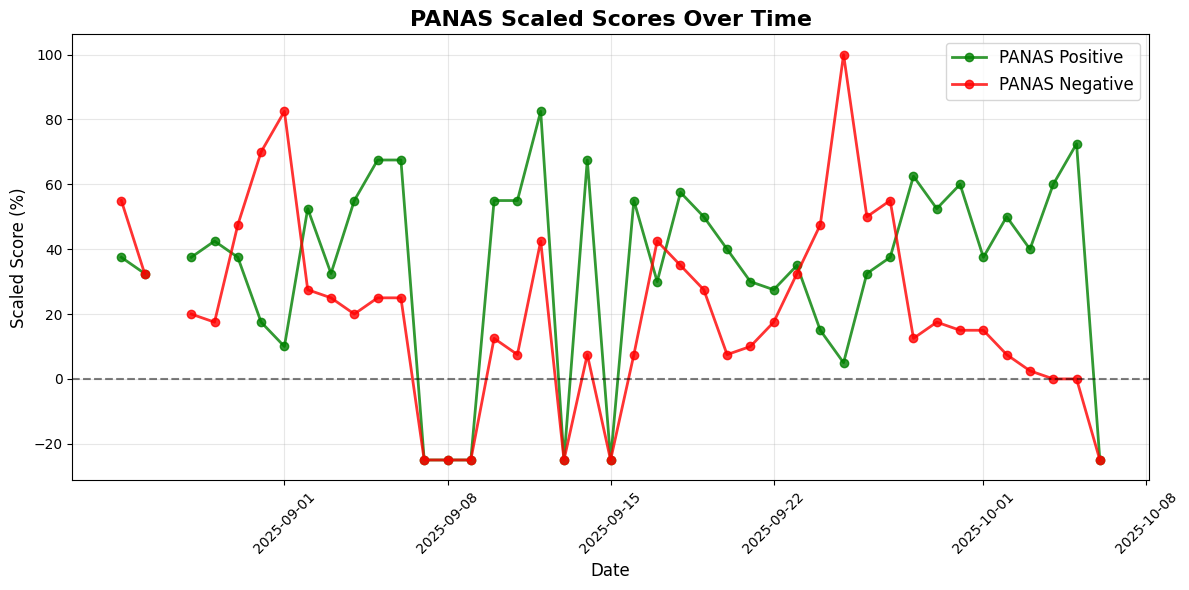


PANAS Positive - Mean: 34.5%, Std: 29.7%
PANAS Negative - Mean: 20.7%, Std: 28.7%
Correlation between Positive and Negative: 0.282


In [24]:
if df is not None and 'panas_pos_scaled' in df.columns and 'panas_neg_scaled' in df.columns:
    # Create the plot
    plt.figure(figsize=(12, 6))
    
    # Plot PANAS Positive and Negative scaled scores
    plt.plot(df['date'], df['panas_pos_scaled'], 'o-', linewidth=2, markersize=6, 
             label='PANAS Positive', color='green', alpha=0.8)
    plt.plot(df['date'], df['panas_neg_scaled'], 'o-', linewidth=2, markersize=6, 
             label='PANAS Negative', color='red', alpha=0.8)
    
    # Customize the plot
    plt.title('PANAS Scaled Scores Over Time', fontsize=16, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Scaled Score (%)', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)
    
    # Add horizontal line at 0 for reference
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    # Show the plot
    plt.show()
    
    # Print some statistics
    print(f"\nPANAS Positive - Mean: {df['panas_pos_scaled'].mean():.1f}%, Std: {df['panas_pos_scaled'].std():.1f}%")
    print(f"PANAS Negative - Mean: {df['panas_neg_scaled'].mean():.1f}%, Std: {df['panas_neg_scaled'].std():.1f}%")
    
    # Show correlation
    correlation = df['panas_pos_scaled'].corr(df['panas_neg_scaled'])
    print(f"Correlation between Positive and Negative: {correlation:.3f}")
    
else:
    print("No PANAS scaled data available to plot")


## Summary Statistics


In [ ]:
if df is not None:
    # Display summary statistics for scaled scores
    scaled_columns = [col for col in df.columns if col.endswith('_scaled')]
    if scaled_columns:
        print("Summary statistics for scaled scores:")
        display(df[scaled_columns].describe())
    
    # Display summary statistics for raw PANAS scores
    panas_columns = [col for col in df.columns if col.startswith('panas_') and not col.endswith('_scaled')]
    if panas_columns:
        print("\nSummary statistics for raw PANAS scores:")
        display(df[panas_columns].describe())


## Export to CSV


In [ ]:
if df is not None:
    # Save to CSV
    output_file = Path("journal_scores.csv")
    df.to_csv(output_file, index=False)
    print(f"DataFrame saved to: {output_file.absolute()}")
    
    # Display file info
    file_size = output_file.stat().st_size
    print(f"File size: {file_size:,} bytes")
    print(f"Rows: {len(df)}, Columns: {len(df.columns)}")
else:
    print("No data to export")


# Extract Journal Scores to DataFrame

This notebook processes all markdown journal files from a specified directory,
extracts wellbeing scores using the existing JournalEntry parsing logic,
and outputs a comprehensive pandas DataFrame with both raw individual scores
and computed scaled metrics.

## Features
- Raw PANAS Positive/Negative scores (20 individual columns)
- Raw BPNS scores (7 individual columns) 
- Raw Flourishing scores (8 individual columns)
- Computed scaled scores (7 columns)
- Console warnings for missing data
- CSV export functionality


## Setup and Imports


In [1]:
import sys
import warnings
from pathlib import Path
from datetime import date
from typing import List, Optional, Dict, Any
import pandas as pd
import numpy as np

# Add the src directory to the path to import minerva_backend modules
sys.path.insert(0, str(Path.cwd().parent / "src"))

from minerva_backend.graph.models.documents import JournalEntry

print("Imports successful!")


Imports successful!


## Helper Functions


In [2]:
def extract_date_from_filename(filename: str) -> Optional[date]:
    """Extract date from filename in format YYYY-MM-DD.md"""
    try:
        # Remove .md extension and parse date
        date_str = filename.replace('.md', '')
        year, month, day = date_str.split('-')
        return date(int(year), int(month), int(day))
    except (ValueError, AttributeError):
        return None

print("Helper functions defined!")


Helper functions defined!


In [3]:
def calculate_scaled_scores(panas_pos: Optional[List[float]], 
                          panas_neg: Optional[List[float]], 
                          bpns: Optional[List[float]], 
                          flourishing: Optional[List[float]]) -> Dict[str, float]:
    """Calculate scaled scores using the formulas from journal markdown files"""
    scores = {}
    
    # PANAS Positive scaled: (sum - 10) / (50 - 10) * 100
    if panas_pos and len(panas_pos) == 10:
        panas_pos_sum = sum(panas_pos)
        scores['panas_pos_scaled'] = (panas_pos_sum - 10) / (50 - 10) * 100
    else:
        scores['panas_pos_scaled'] = np.nan
    
    # PANAS Negative scaled: (sum - 10) / (50 - 10) * 100
    if panas_neg and len(panas_neg) == 10:
        panas_neg_sum = sum(panas_neg)
        scores['panas_neg_scaled'] = (panas_neg_sum - 10) / (50 - 10) * 100
    else:
        scores['panas_neg_scaled'] = np.nan
    
    # BPNS scores (7 items total: 2 autonomy + 2 competence + 3 relatedness)
    if bpns and len(bpns) == 7:
        autonomy_sum = bpns[0] + bpns[1]  # First 2 items
        competence_sum = bpns[2] + bpns[3]  # Next 2 items
        relatedness_sum = bpns[4] + bpns[5] + bpns[6]  # Last 3 items
        bpns_total = autonomy_sum + competence_sum + relatedness_sum
        
        # Individual scaled scores
        scores['bpns_autonomy_scaled'] = (autonomy_sum - 2) / (14 - 2) * 100
        scores['bpns_competence_scaled'] = (competence_sum - 2) / (14 - 2) * 100
        scores['bpns_relatedness_scaled'] = (relatedness_sum - 3) / (21 - 3) * 100
        scores['bpns_total_scaled'] = (bpns_total - 7) / (49 - 7) * 100
    else:
        scores['bpns_autonomy_scaled'] = np.nan
        scores['bpns_competence_scaled'] = np.nan
        scores['bpns_relatedness_scaled'] = np.nan
        scores['bpns_total_scaled'] = np.nan
    
    # Flourishing scaled: (sum - 8) / (56 - 8) * 100
    if flourishing and len(flourishing) == 8:
        flourishing_sum = sum(flourishing)
        scores['flourishing_scaled'] = (flourishing_sum - 8) / (56 - 8) * 100
    else:
        scores['flourishing_scaled'] = np.nan
    
    return scores

print("Scaled score calculation function defined!")


Scaled score calculation function defined!


In [4]:
def extract_raw_scores(panas_pos: Optional[List[float]], 
                      panas_neg: Optional[List[float]], 
                      bpns: Optional[List[float]], 
                      flourishing: Optional[List[float]]) -> Dict[str, Any]:
    """Extract individual raw scores into separate columns"""
    scores = {}
    
    # PANAS Positive scores (10 items)
    panas_pos_labels = ['interested', 'excited', 'strong', 'enthusiastic', 'proud', 
                       'alert', 'inspired', 'determined', 'attentive', 'active']
    if panas_pos and len(panas_pos) == 10:
        for i, label in enumerate(panas_pos_labels):
            scores[f'panas_pos_{label}'] = panas_pos[i]
    else:
        for label in panas_pos_labels:
            scores[f'panas_pos_{label}'] = np.nan
    
    # PANAS Negative scores (10 items)
    panas_neg_labels = ['distressed', 'upset', 'guilty', 'scared', 'hostile', 
                       'irritable', 'ashamed', 'nervous', 'jittery', 'afraid']
    if panas_neg and len(panas_neg) == 10:
        for i, label in enumerate(panas_neg_labels):
            scores[f'panas_neg_{label}'] = panas_neg[i]
    else:
        for label in panas_neg_labels:
            scores[f'panas_neg_{label}'] = np.nan
    
    # BPNS scores (7 items)
    bpns_labels = ['autonomy_choices', 'autonomy_tasks', 'competence_capable', 
                  'competence_challenges', 'relatedness_connected', 'relatedness_along', 
                  'relatedness_supported']
    if bpns and len(bpns) == 7:
        for i, label in enumerate(bpns_labels):
            scores[f'bpns_{label}'] = bpns[i]
    else:
        for label in bpns_labels:
            scores[f'bpns_{label}'] = np.nan
    
    # Flourishing scores (8 items)
    flourishing_labels = ['purposeful', 'relationships', 'engaged', 'contribute', 
                         'competent', 'good_person', 'optimistic', 'respected']
    if flourishing and len(flourishing) == 8:
        for i, label in enumerate(flourishing_labels):
            scores[f'flourishing_{label}'] = flourishing[i]
    else:
        for label in flourishing_labels:
            scores[f'flourishing_{label}'] = np.nan
    
    return scores

print("Raw score extraction function defined!")


Raw score extraction function defined!


In [5]:
def process_journal_file(file_path: Path) -> Optional[Dict[str, Any]]:
    """Process a single journal file and extract all scores"""
    try:
        # Read file content
        with open(file_path, 'r', encoding='utf-8') as f:
            content = f.read()
        
        # Extract date from filename
        journal_date = extract_date_from_filename(file_path.name)
        if not journal_date:
            print(f"WARNING: Could not extract date from filename: {file_path.name}")
            return None
        
        # Parse journal entry using existing JournalEntry logic
        journal_entry = JournalEntry.from_text(content, journal_date.isoformat())
        
        # Prepare result dictionary
        result = {'date': journal_date}
        
        # Check for missing scores and print warnings
        filename = file_path.name
        if not journal_entry.panas_pos:
            print(f"WARNING: Missing PANAS positive scores for {filename}")
        if not journal_entry.panas_neg:
            print(f"WARNING: Missing PANAS negative scores for {filename}")
        if not journal_entry.bpns:
            print(f"WARNING: Missing BPNS scores for {filename}")
        if not journal_entry.flourishing:
            print(f"WARNING: Missing Flourishing scores for {filename}")
        
        # Extract raw scores
        raw_scores = extract_raw_scores(
            journal_entry.panas_pos,
            journal_entry.panas_neg,
            journal_entry.bpns,
            journal_entry.flourishing
        )
        result.update(raw_scores)
        
        # Calculate scaled scores
        scaled_scores = calculate_scaled_scores(
            journal_entry.panas_pos,
            journal_entry.panas_neg,
            journal_entry.bpns,
            journal_entry.flourishing
        )
        result.update(scaled_scores)
        
        return result
        
    except Exception as e:
        print(f"ERROR: Failed to process {file_path.name}: {e}")
        return None

print("Journal file processing function defined!")


Journal file processing function defined!


## Configuration

Set the directory path to process. Default is `D:\yo\02 - Daily Notes`


In [6]:
# Set the directory path to process
directory_path = Path(r"D:\yo\02 - Daily Notes")

# Alternative: Use test data
# directory_path = Path("../test_scripts/notes")

print(f"Target directory: {directory_path}")
print(f"Directory exists: {directory_path.exists()}")


Target directory: D:\yo\02 - Daily Notes
Directory exists: True


## Process Journal Files


In [7]:
# Check if directory exists
if not directory_path.exists():
    print(f"ERROR: Directory does not exist: {directory_path}")
    print("Please update the directory_path variable above.")
else:
    print(f"Processing journal files from: {directory_path}")
    
    # Find all .md files
    md_files = list(directory_path.glob("*.md"))
    if not md_files:
        print("No .md files found in the directory")
    else:
        print(f"Found {len(md_files)} markdown files")
        print("Files to process:")
        for file_path in sorted(md_files):
            print(f"  - {file_path.name}")


Processing journal files from: D:\yo\02 - Daily Notes
Found 88 markdown files
Files to process:
  - 2025-02-16.md
  - 2025-03-22.md
  - 2025-04-11.md
  - 2025-05-20.md
  - 2025-07-13.md
  - 2025-07-15.md
  - 2025-07-17.md
  - 2025-07-18.md
  - 2025-07-19.md
  - 2025-07-20.md
  - 2025-07-21.md
  - 2025-07-22.md
  - 2025-07-23.md
  - 2025-07-24.md
  - 2025-07-25.md
  - 2025-07-26.md
  - 2025-07-27.md
  - 2025-07-28.md
  - 2025-07-29.md
  - 2025-07-30.md
  - 2025-07-31.md
  - 2025-08-01.md
  - 2025-08-02.md
  - 2025-08-03.md
  - 2025-08-04.md
  - 2025-08-05.md
  - 2025-08-06.md
  - 2025-08-07.md
  - 2025-08-08.md
  - 2025-08-09.md
  - 2025-08-10.md
  - 2025-08-11.md
  - 2025-08-12.md
  - 2025-08-13.md
  - 2025-08-14.md
  - 2025-08-15.md
  - 2025-08-16.md
  - 2025-08-17.md
  - 2025-08-18.md
  - 2025-08-19.md
  - 2025-08-20.md
  - 2025-08-21.md
  - 2025-08-22.md
  - 2025-08-23.md
  - 2025-08-24.md
  - 2025-08-25.md
  - 2025-08-26.md
  - 2025-08-27.md
  - 2025-08-28.md
  - 2025-08-29.md
  - 

In [8]:
# Process each file
if directory_path.exists() and md_files:
    all_scores = []
    
    for file_path in sorted(md_files):
        print(f"\nProcessing: {file_path.name}")
        scores = process_journal_file(file_path)
        if scores:
            all_scores.append(scores)
            print(f"  ✓ Successfully processed")
        else:
            print(f"  ✗ Failed to process")
    
    print(f"\nTotal files processed: {len(all_scores)} out of {len(md_files)}")
else:
    all_scores = []
    print("No files to process.")



Processing: 2025-02-16.md
  ✓ Successfully processed

Processing: 2025-03-22.md
  ✓ Successfully processed

Processing: 2025-04-11.md
  ✓ Successfully processed

Processing: 2025-05-20.md
  ✓ Successfully processed

Processing: 2025-07-13.md
  ✓ Successfully processed

Processing: 2025-07-15.md
  ✓ Successfully processed

Processing: 2025-07-17.md
  ✓ Successfully processed

Processing: 2025-07-18.md
  ✓ Successfully processed

Processing: 2025-07-19.md
  ✓ Successfully processed

Processing: 2025-07-20.md
  ✓ Successfully processed

Processing: 2025-07-21.md
  ✓ Successfully processed

Processing: 2025-07-22.md
  ✓ Successfully processed

Processing: 2025-07-23.md
  ✓ Successfully processed

Processing: 2025-07-24.md
  ✓ Successfully processed

Processing: 2025-07-25.md
  ✓ Successfully processed

Processing: 2025-07-26.md
  ✓ Successfully processed

Processing: 2025-07-27.md
  ✓ Successfully processed

Processing: 2025-07-28.md
  ✓ Successfully processed

Processing: 2025-07-29.md
 

## Create DataFrame


In [9]:
if all_scores:
    # Create DataFrame
    df = pd.DataFrame(all_scores)
    
    # Sort by date
    df = df.sort_values('date').reset_index(drop=True)
    
    print(f"Successfully created DataFrame with {len(df)} journal entries")
    print(f"DataFrame shape: {df.shape}")
    print(f"Columns: {len(df.columns)}")
else:
    print("No data to create DataFrame")
    df = None


Successfully created DataFrame with 88 journal entries
DataFrame shape: (88, 43)
Columns: 43


## Display DataFrame Information


In [10]:
if df is not None:
    print("DataFrame Info:")
    print(df.info())
    
    print("\nFirst 5 rows:")
    display(df.head())
    
    print("\nLast 5 rows:")
    display(df.tail())


DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 43 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   date                        88 non-null     object 
 1   panas_pos_interested        42 non-null     float64
 2   panas_pos_excited           42 non-null     float64
 3   panas_pos_strong            42 non-null     float64
 4   panas_pos_enthusiastic      42 non-null     float64
 5   panas_pos_proud             42 non-null     float64
 6   panas_pos_alert             42 non-null     float64
 7   panas_pos_inspired          42 non-null     float64
 8   panas_pos_determined        42 non-null     float64
 9   panas_pos_attentive         42 non-null     float64
 10  panas_pos_active            42 non-null     float64
 11  panas_neg_distressed        42 non-null     float64
 12  panas_neg_upset             42 non-null     float64
 13  panas_neg_guilty     

,date,panas_pos_interested,panas_pos_excited,panas_pos_strong,panas_pos_enthusiastic,panas_pos_proud,panas_pos_alert,panas_pos_inspired,panas_pos_determined,panas_pos_attentive,...,flourishing_good_person,flourishing_optimistic,flourishing_respected,panas_pos_scaled,panas_neg_scaled,bpns_autonomy_scaled,bpns_competence_scaled,bpns_relatedness_scaled,bpns_total_scaled,flourishing_scaled
0,2025-02-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-03-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2025-04-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2025-05-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2025-07-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Last 5 rows:


,date,panas_pos_interested,panas_pos_excited,panas_pos_strong,panas_pos_enthusiastic,panas_pos_proud,panas_pos_alert,panas_pos_inspired,panas_pos_determined,panas_pos_attentive,...,flourishing_good_person,flourishing_optimistic,flourishing_respected,panas_pos_scaled,panas_neg_scaled,bpns_autonomy_scaled,bpns_competence_scaled,bpns_relatedness_scaled,bpns_total_scaled,flourishing_scaled
83,2025-10-02,3.0,2.0,3.0,4.0,3.0,2.0,3.0,3.0,4.0,...,4.0,4.0,4.0,50.0,7.5,66.666667,83.333333,77.777778,76.190476,56.250000
84,2025-10-03,3.0,3.0,2.0,3.0,3.0,2.0,2.0,4.0,2.0,...,5.0,4.0,5.0,40.0,2.5,75.000000,58.333333,83.333333,73.809524,58.333333
85,2025-10-04,3.0,4.0,3.0,3.0,3.0,3.0,4.0,4.0,3.0,...,6.0,4.0,4.0,60.0,0.0,83.333333,75.000000,94.444444,85.714286,75.000000
86,2025-10-05,4.0,4.0,4.0,4.0,4.0,4.0,3.0,4.0,4.0,...,6.0,5.0,4.0,72.5,0.0,66.666667,83.333333,83.333333,78.571429,70.833333
87,2025-10-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-25.0,-25.0,-16.666667,-16.666667,-16.666667,-16.666667,-16.666667


## Summary Statistics


In [11]:
if df is not None:
    # Display summary statistics for scaled scores
    scaled_columns = [col for col in df.columns if col.endswith('_scaled')]
    if scaled_columns:
        print("Summary statistics for scaled scores:")
        display(df[scaled_columns].describe())
    
    # Display summary statistics for raw PANAS scores
    panas_columns = [col for col in df.columns if col.startswith('panas_') and not col.endswith('_scaled')]
    if panas_columns:
        print("\nSummary statistics for raw PANAS scores:")
        display(df[panas_columns].describe())


Summary statistics for scaled scores:


,panas_pos_scaled,panas_neg_scaled,bpns_autonomy_scaled,bpns_competence_scaled,bpns_relatedness_scaled,bpns_total_scaled,flourishing_scaled
count,42.00000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000
mean,34.52381,20.714286,54.365079,50.198413,39.021164,46.598639,38.988095
std,29.66910,28.671211,34.835954,35.901481,33.725964,32.608440,28.387851
min,-25.00000,-25.000000,-16.666667,-16.666667,-16.666667,-16.666667,-16.666667
25%,28.12500,7.500000,50.000000,33.333333,15.277778,33.928571,35.416667
50%,37.50000,17.500000,66.666667,66.666667,44.444444,57.142857,47.916667
75%,55.00000,34.375000,75.000000,75.000000,70.833333,70.238095,58.333333
max,82.50000,100.000000,100.000000,100.000000,94.444444,85.714286,75.000000



Summary statistics for raw PANAS scores:


,panas_pos_interested,panas_pos_excited,panas_pos_strong,panas_pos_enthusiastic,panas_pos_proud,panas_pos_alert,panas_pos_inspired,panas_pos_determined,panas_pos_attentive,panas_pos_active,panas_neg_distressed,panas_neg_upset,panas_neg_guilty,panas_neg_scared,panas_neg_hostile,panas_neg_irritable,panas_neg_ashamed,panas_neg_nervous,panas_neg_jittery,panas_neg_afraid
count,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.00000,42.000000
mean,3.142857,2.380952,2.452381,2.452381,2.523810,1.952381,2.000000,2.761905,1.952381,2.190476,1.785714,2.142857,1.738095,1.547619,1.380952,1.904762,1.952381,2.476190,1.52381,1.833333
std,1.631570,1.413392,1.291669,1.400390,1.383493,1.103263,1.126185,1.393531,1.305754,1.311080,1.353148,1.406803,1.083345,1.193527,1.208756,1.393531,1.228769,1.565452,1.06469,1.305087
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,3.000000,1.000000,2.000000,2.000000,2.000000,1.000000,1.250000,2.250000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.250000,1.00000,1.000000
50%,3.500000,3.000000,3.000000,3.000000,3.000000,2.000000,2.000000,3.000000,2.000000,2.000000,1.000000,2.000000,2.000000,1.000000,1.000000,2.000000,2.000000,2.000000,1.00000,2.000000
75%,4.000000,3.000000,3.000000,3.750000,3.750000,3.000000,3.000000,4.000000,3.000000,3.000000,3.000000,3.000000,2.000000,2.000000,1.000000,3.000000,2.000000,4.000000,2.00000,2.000000
max,6.000000,5.000000,5.000000,5.000000,5.000000,4.000000,4.000000,6.000000,6.000000,4.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.00000,5.000000


<Axes: >

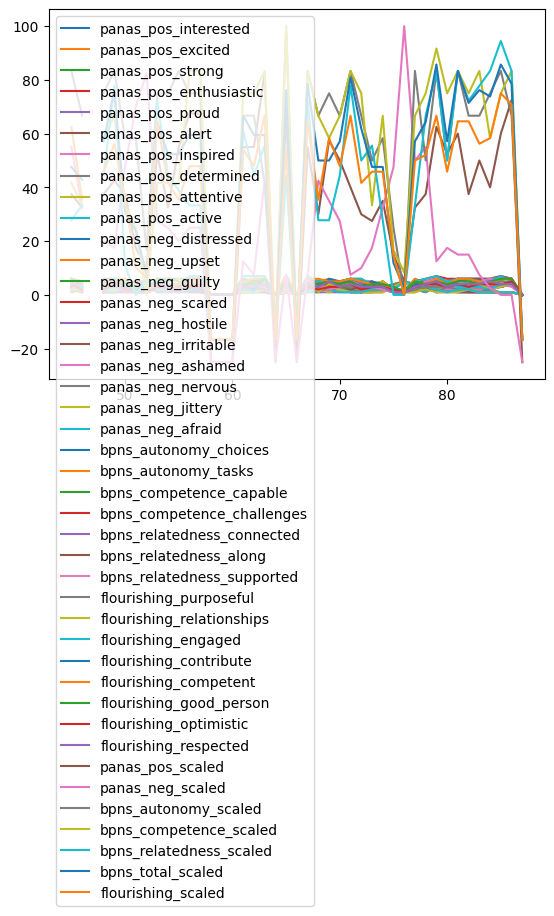

## Export to CSV


In [ ]:
if df is not None:
    # Save to CSV
    output_file = Path("journal_scores.csv")
    df.to_csv(output_file, index=False)
    print(f"DataFrame saved to: {output_file.absolute()}")
    
    # Display file info
    file_size = output_file.stat().st_size
    print(f"File size: {file_size:,} bytes")
    print(f"Rows: {len(df)}, Columns: {len(df.columns)}")
else:
    print("No data to export")
